# Read master Data frame

In [3]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime
%matplotlib notebook 

In [10]:
df = pd.read_csv('Solarcast-01_Master_Cleaned_Sorted.csv')

# Group by device_urn

In [26]:
gf = df.groupby('device')

In [27]:
devices = np.unique(df.device)

In [28]:
devices.shape

(36,)

In [29]:
def plotTimeSeries(ts):
    """
    Function to plot the time series of ts (e.g. 'bat_voltage') for all the devices in question
    args:
        ts: time series column string name "bat_voltage"
    """
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = iter(cm.rainbow(np.linspace(0, 1, len(devices))))
    for device in devices:
        s1  = gf.get_group(device)
#         print(pd.Index(s1['when_captured']).is_monotonic)
        ax.plot(s1['when_captured'].values ,s1[ts],'o-', label='{}'.format(device), color= next(colors))
    
    # Set title and labels for axes
    ax.set(xlabel="Date-Time", ylabel=ts ,title = ts)
#     ax.legend()
    plt.show()
#     print(pd.Index(s1['when_captured']).is_monotonic)

# Plot all the time series

<IPython.core.display.Javascript object>


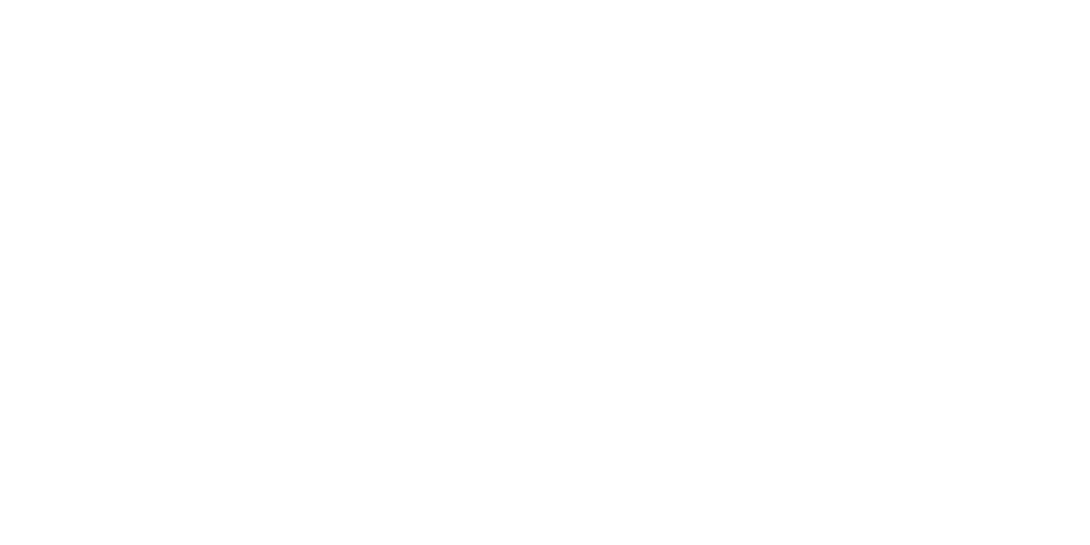

In [31]:
plotTimeSeries('pms_pm01_0')

In [ ]:
plotTimeSeries('pms_pm02_5')

In [ ]:
plotTimeSeries('pms_pm10_0')

In [ ]:
plotTimeSeries('bat_voltage')

In [ ]:
plotTimeSeries('env_temp')

In [ ]:
plotTimeSeries('env_humid')

In [ ]:
plotTimeSeries('lnd_7318c')

<IPython.core.display.Javascript object>


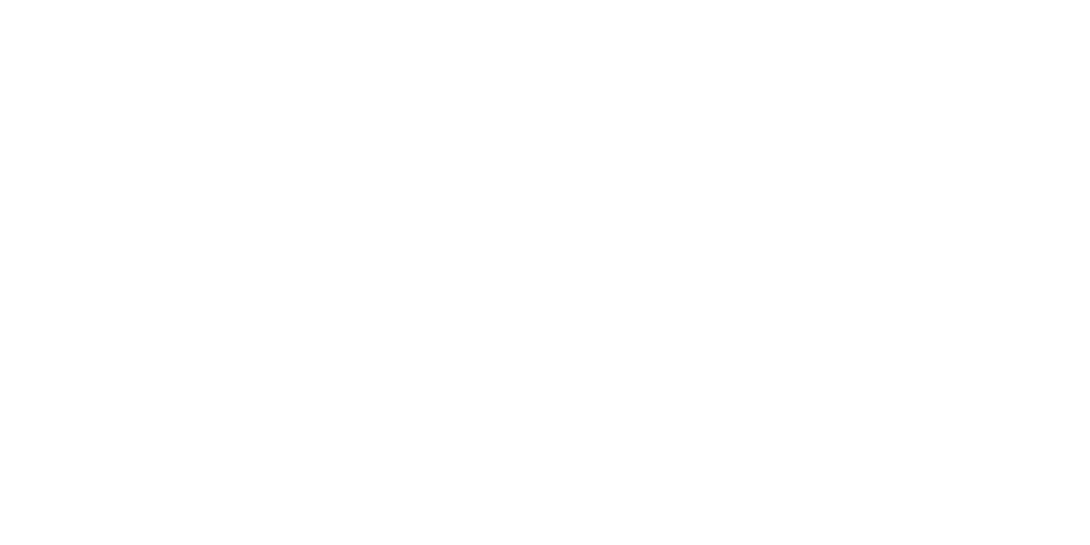

KeyboardInterrupt: 

In [30]:
plotTimeSeries('lnd_7318u')

## Time Series as a Pandas Time series

In [4]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict
import datetime
# without mpld3
%matplotlib notebook 

In [5]:
col = 'env_temp'
dev = devices[1]

ts = df[(df['device_sn']==dev)].loc[:,['when_captured', col]]
ts = ts[ts[col].notna()]

ts_dateTime = ts.when_captured.values
ts_indices  = ts.when_captured.values.astype(int)
ts_data = ts[col].values

ts.shape

# dt_temp = ts.iloc[0,0]
# # COnvert pandas datetime or Timestamp object to numpy datetime64 int
# pd.Timestamp.to_datetime64(ts.iloc[0,0]).astype(int)

# # COnvert numpy datetime64 int to pandas datetime or Timestamp object
# pd.to_datetime(pd.Timestamp.to_datetime64(ts.iloc[0,0]).astype(int), utc=True)

NameError: name 'devices' is not defined

> *Key note
For many quantities such as temperature, humidity, radiation levels, there is an underlying seasonality (here on the scale of hours). I will filter out this seasonal trend via an additive time series model so as to be able to implement below anomaly detection on a stationary version of the time series(one where the mean is not a function of time). [See here](https://medium.com/datadriveninvestor/step-by-step-time-series-analysis-d2f117554d7e)*

## Check for stationarity
The idea is to check for stationarity of the time series (stationary mean, stddev). If non-stationary, separate out the seasonal and trend components and operate the anomaly detection on the residuals. 

First step: check for stationarity using the Augmented Dickey Fuller Test (ADF) to check for stationarity of the time series of interest. ADF test gives us the

   - test statistics,
   - p-value and
   - critical values.
    
If test statistic > critical value, it implies that the series is not stationary.

or

If p>0.05 then fail to reject the null hypothesis. This means that time series has unit root and is not stationary

If p-value <= 0.05: Reject the null hypothesis , the data does not have a unit root and is stationary

In [901]:
ts

,when_captured,env_temp
64579,2017-09-07 08:18:54+00:00,15.825
64578,2017-09-07 08:48:54+00:00,15.897
64440,2017-09-07 09:18:54+00:00,15.975
64439,2017-09-07 09:48:54+00:00,16.124
64437,2017-09-07 10:19:24+00:00,16.129
...,...,...
288,2017-09-30 21:11:00+00:00,15.445
287,2017-09-30 21:41:00+00:00,14.374
128,2017-09-30 22:11:00+00:00,13.237
131,2017-09-30 22:41:00+00:00,12.403


In [902]:
from statsmodels.tsa.stattools import adfuller

In [905]:
ts = pd.Series(ts_data, index=ts_dateTime)
X = ts.values

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.222530
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


## Finding Trend, Seasonality, Cyclicity, Residual  -- Additive Decomposition

Comparison of the test statistic and critical values tells it is definitely non-stationary; so we try to do an additive decomposition

In [906]:
ts = pd.Series(ts_data, index=ts_dateTime)
print(ts.index.inferred_freq )
per = int(np.subtract(ts_dateTime[10], ts_dateTime[0],casting="unsafe")*2.7778e-13)# appro
per = 1/7/24/6
print(per)
print(ts)
#The `seasonal_decompose()` function needs a parameter called `freq`, which could be computed 
#from the Pandas Timeseries, but is not fully functional right now. So we have to specify it for ourselves. 
#The frequency of decomposition must be an interval, which ‘may’ repeat. Like a hour, a week, a day 
#or something one is interested in.  Our data is stored with 15min resolution and I want to see a 
#weekly seasonality, so our `freq` is
#decompfreq=24h⋅60min15min⋅7days
# decompfreq = 24*60/15*7

None
0.000992063492063492
2017-09-07 08:18:54    15.825
2017-09-07 08:48:54    15.897
2017-09-07 09:18:54    15.975
2017-09-07 09:48:54    16.124
2017-09-07 10:19:24    16.129
                        ...  
2017-09-30 21:11:00    15.445
2017-09-30 21:41:00    14.374
2017-09-30 22:11:00    13.237
2017-09-30 22:41:00    12.403
2017-09-30 23:11:30    12.027
Length: 1157, dtype: float64



The seasonal component is first removed by applying a convolution
filter to the data. The average of this smoothed series for each
period is the returned seasonal component.

<IPython.core.display.Javascript object>


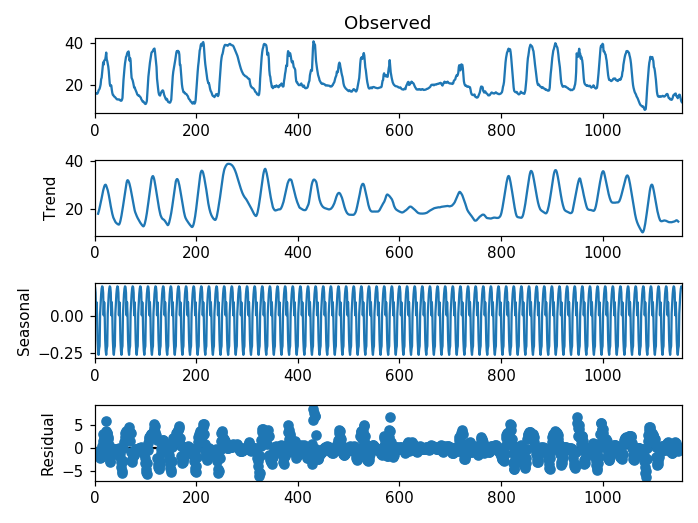

In [960]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts.values, model='additive', period=15)
# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)
result.plot()
plt.show()

## Testing fft on data to filter underlying seasonality and cyclicity
Take the discrete Fourier transform of the signal, and plot the real number corresponding to the magnitude of each coefficient of the Fourier transform. The great thing about taking the Python DFT is that it is implemented using a cool algorithm (FFT) that runs in near linear time (technically $O(Nlog(N))$) in the length of the vector (think a single pass efficiency! that's very good for bulky data).

In [919]:
# sampleRate = 1/30/60 # in seconds-inverse
# timestep = 1/sampleRate # in seconds : 1 reading every ~ 30 mins
# recordTime = (np.diff([ts_times[0], ts_times[-1]])/10E9/60).astype(int) # in seconds
# recordTime

<IPython.core.display.Javascript object>


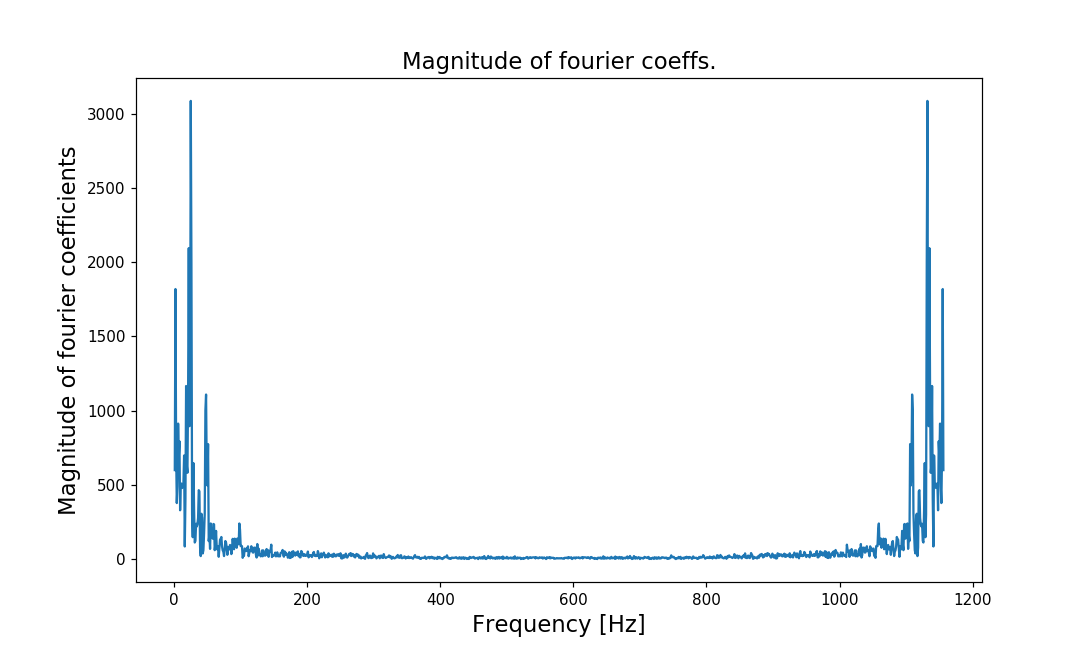

Text(0, 0.5, 'Magnitude of fourier coefficients')

In [920]:
sp = np.fft.fft(ts_data)
plt.figure(figsize = (10,6))
plt.plot(np.arange(len(sp))[1:], abs(sp)[1:])
plt.xlabel('Frequency [Hz]', fontsize = 15)
plt.title("Magnitude of fourier coeffs.", fontsize = 15)
plt.ylabel('Magnitude of fourier coefficients', fontsize = 15)

In [957]:
def thresholding(sp, limit, threshold):
    """
    Thresholding function to curb frequencies beyong a threshold
    args:
        limit: Thresholding Type : "Upper" or "Lower"  
                            -- "Upper" corresponds to zeroing out on the higher frequencies
                            -- "Lower" corresponds to zeroing out on the lower frequencies
        threshold: thresholding frequency
    """
    if limit=='Upper':
        c1=1
        c2=0
    elif limit=='Lower':
        c1=0
        c2=1

    thresholdedFFT = np.hstack((c1*sp[0:threshold],c2*sp[threshold:-threshold], c1*sp[-threshold:])).ravel()
    plt.figure()
    plt.plot(np.arange(len(sp)), abs(thresholdedFFT))
    plt.xlabel('Frequency [Hz]', fontsize = 15)
    plt.title(limit + " Thresholded signal FFT", fontsize = 15)
    plt.ylabel('Magnitude of fourier coefficients', fontsize = 12)
    test_o = np.fft.ifft(thresholdedFFT)
    print('filtered ts_data: ' ,abs(test_o))
    print('ts_data:', ts_data)
    # audio signal written to current directory for listening
    plt.figure()
    plt.plot(test_o, label = 'filtered')
    plt.plot(ts_data, label = 'original')
    plt.legend()
    plt.xlabel('time steps', fontsize = 15)
    plt.ylabel('Signal ',fontsize = 13)
    fname = 'testing'+limit

<IPython.core.display.Javascript object>


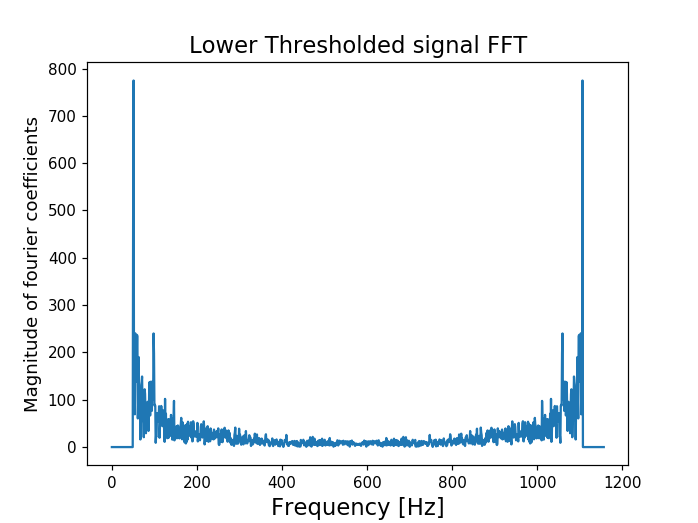

filtered ts_data:  [3.46645044 3.84362006 3.98407393 ... 1.13849808 1.19502261 0.89714239]
ts_data: [15.825 15.897 15.975 ... 13.237 12.403 12.027]


<IPython.core.display.Javascript object>


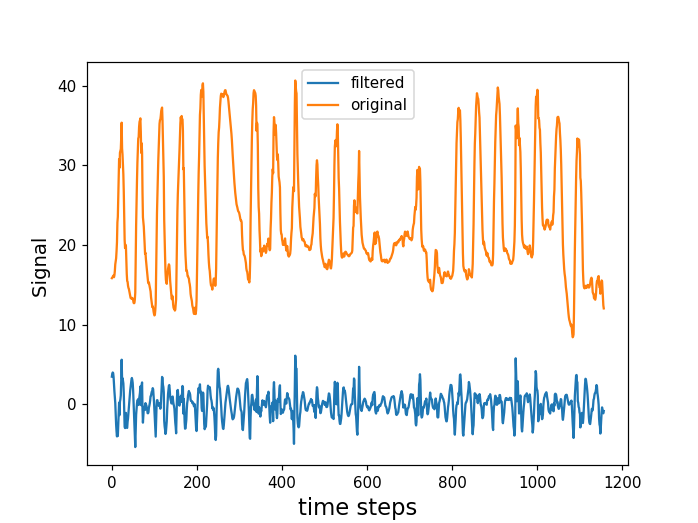

/Users/stanforduser/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [958]:
threshold =  50
thresholding(sp, 'Lower', threshold)

## Testing anomaly detection

In [714]:
import time
import luminol
from luminol.modules.time_series import TimeSeries
from luminol.utils import to_epoch
from luminol.anomaly_detector import AnomalyDetector

In [816]:
# testing luminol anomaly detection
ts = pd.Series(ts_data, index=ts_indices)

In [802]:
# Luminol compatible format of the time series
ts = TimeSeries(ts.to_dict())

Notes:

1. `algorithm_name='derivative_detector', algorithm_params={'smoothing_factor':0.1}` with `score_threshold` as 0.8Xmaximum score of the anomalies works well for radiation data 'lnd..c'
2. Figure out how to do anomaly detection for a series where there is periodicity
3. `algorithm_name='exp_avg_detector'` not too bad for `pms_pm01_0`. 

In [804]:
my_detector = AnomalyDetector(ts, algorithm_name='derivative_detector', algorithm_params={'smoothing_factor':0.1})
score = my_detector.get_all_scores()
anomalies = my_detector.get_anomalies()

In [805]:
anom_score=[]
for (timestamp, value) in score.iteritems():
    t_str = pd.to_datetime(timestamp, utc=True)
    anom_score.append([t_str, value])

In [806]:
anom_time_windows = []
for an in anomalies:
    start, end = an.get_time_window()
    anom_time_windows.append((pd.to_datetime(start, utc=True), pd.to_datetime(end, utc=True), an.anomaly_score))
#     print("Anomaly from {0} to {1} with score {2}".format\
#           (pd.to_datetime(an.start_timestamp, utc=True), \
#            pd.to_datetime(an.end_timestamp, utc=True), \
#            an.anomaly_score))

In [807]:
Ascores = [anom_time_windows[i][2] for i in range(len(anom_time_windows))]

In [808]:
len(anom_time_windows)

436

In [809]:
len(anom_score)

2252

In [810]:
len(ts)

2252

In [811]:
ts_times = pd.to_datetime(ts_indices, utc=True)
ts_times = [pd.Timestamp.to_datetime64(ts_times[i]) for i in range(len(ts_times))]

score_times = [pd.Timestamp.to_datetime64(anom_score[i][0]) for i in range(len(anom_score))]

assert(score_times==ts_times)

In [812]:
if Ascores == []:
    score_threshold = 0.1
else:
    score_threshold = 0.8*max(Ascores)
score_threshold

6.9566307285100395

In [813]:
scores = [anom_score[i][1] if anom_score[i][1]> score_threshold else 0 for i in range(len(anom_score))]

<IPython.core.display.Javascript object>


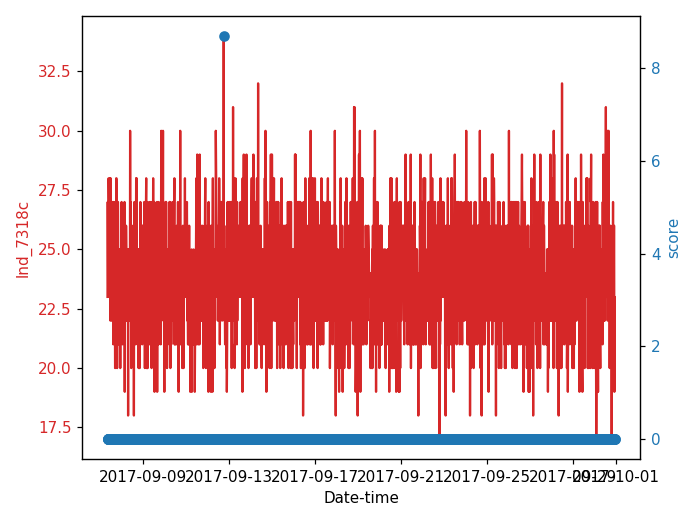

In [814]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date-time')
ax1.set_ylabel(col, color=color)
ax1.plot(ts_times, ts_data,  color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('score', color=color)  # we already handled the x-label with ax1
ax2.plot(ts_times, scores, 'o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()